In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

In [7]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    #transforms.ToPILImage(),  
     # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [8]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [10]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)

print(torch.is_tensor(image))
#plt.imshow(image[0][0], cmap="gray")

torch.Size([256, 1, 28, 28]) torch.Size([256])
True


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cpu()
#model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

In [21]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cpu(), label.cpu()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [29]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [ ]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.665697
Epoch: 1 	Validation Loss: 0.457161, Accuracy: 0.830100
Epoch: 2 	Training Loss: 0.421853
Epoch: 2 	Validation Loss: 0.379021, Accuracy: 0.863500
Epoch: 3 	Training Loss: 0.362196
Epoch: 3 	Validation Loss: 0.340399, Accuracy: 0.875700
Epoch: 4 	Training Loss: 0.328529
Epoch: 4 	Validation Loss: 0.311952, Accuracy: 0.886400
Epoch: 5 	Training Loss: 0.305997
Epoch: 5 	Validation Loss: 0.307244, Accuracy: 0.887700
Epoch: 6 	Training Loss: 0.286261
Epoch: 6 	Validation Loss: 0.273481, Accuracy: 0.900500
Epoch: 7 	Training Loss: 0.273616
Epoch: 7 	Validation Loss: 0.269365, Accuracy: 0.902300
Epoch: 8 	Training Loss: 0.263183
Epoch: 8 	Validation Loss: 0.285598, Accuracy: 0.893700
Epoch: 9 	Training Loss: 0.245722
Epoch: 9 	Validation Loss: 0.253453, Accuracy: 0.908400
Epoch: 10 	Training Loss: 0.244101
Epoch: 10 	Validation Loss: 0.247243, Accuracy: 0.909500
Epoch: 11 	Training Loss: 0.233620
Epoch: 11 	Validation Loss: 0.241788, Accuracy: 0.911000
Epoch:

In [ ]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)

In [ ]:
import torch
from torch import autograd

x=torch.tensor(1.)
a=torch.tensor(1.,requires_grad=True)
b=torch.tensor(2.,requires_grad=True)
c=torch.tensor(3.,requires_grad=True)

y=a**2*x+b*x+c

print('before:',a.grad,b.grad,c.grad)
grads=autograd.grad(y,[a,b,c])
print('after:',grads[0],grads[1],grads[2])



import matplotlib.pyplot as plt

plt.scatter(y,x)
plt.show()


In [3]:
print(grads[0].values)
print(grads[0].size)

<built-in method values of Tensor object at 0x0000014D367F6C70>
<built-in method size of Tensor object at 0x0000014D367F6C70>


In [4]:
import torch

print(torch.__version__)
print('gpu:',torch.cuda.is_available())

2.0.0+cu117
gpu: False


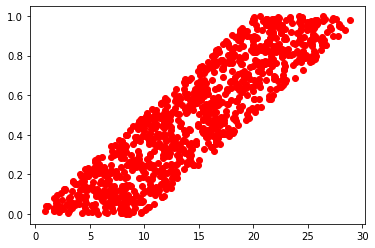

In [27]:
import matplotlib.pyplot as plt
import numpy as np

noise=np.random.rand(1,1000)
x=np.random.rand(1,1000)
y=x*2*10 +noise*10

#print(x)
#print(y)

plt.scatter(y,x,color='r')
plt.show()

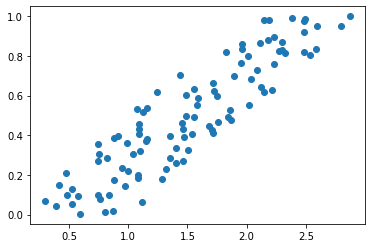

In [78]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [95]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
 
print(len(training_data))

60000


In [97]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
#print(test_dataloader[:,2])
for X, y in test_dataloader:
    print(X[1:3])
    print("x length:",len(X))
    print(y)
    print(len(y))
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
x length: 64
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])
64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [31]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [63]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        if batch % 100 == 0:           
            loss, current = loss.item(), (batch + 1) * len(X)
            losssave.append(loss/len(dataloader.dataset))
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [98]:
import matplotlib.pyplot as plt

if __name__ == '__main__':
    losssave=[]
    accurity=[]
    epochs = 1
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
    print("Done!")
    print(losssave)
    

Epoch 1
-------------------------------
loss: 0.585883  [   64/60000]
loss: 0.685476  [ 6464/60000]
loss: 0.466858  [12864/60000]
loss: 0.703241  [19264/60000]
loss: 0.624838  [25664/60000]
loss: 0.614663  [32064/60000]
loss: 0.654419  [38464/60000]
loss: 0.689448  [44864/60000]
loss: 0.689676  [51264/60000]
loss: 0.636758  [57664/60000]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.629698 

Done!
[9.764711062113444e-06, 1.14246000846227e-05, 7.780962685743967e-06, 1.1720686157544453e-05, 1.0413960615793864e-05, 1.0244378447532654e-05, 1.090698738892873e-05, 1.1490801970163982e-05, 1.149459977944692e-05, 1.061263382434845e-05]


In [99]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [100]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [106]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"


In [107]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [72]:
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
 
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.tensor([44, 55, 66, 44, 55, 66, 44, 55, 66, 44, 55, 66])
train_ids = TensorDataset(a, b)#封装数据a与标签b
 
# 切片输出
print(train_ids[0:2])
print('=' * 80)
# 循环取数据
for x_train, y_label in train_ids:
    print(x_train, y_label)
# DataLoader进行数据封装
print('=' * 80)
 
train_loader = DataLoader(dataset=train_ids, batch_size=4, shuffle=True)
for i, data in enumerate(train_loader):  # 注意enumerate返回值有两个,一个是序号，一个是数据（包含训练数据和标签）
    x_data, label = data
    print(' batch:{0}\n x_data:{1}\nlabel: {2}'.format(i, x_data, label))
for i, data in enumerate(train_loader,1):  # 注意enumerate返回值有两个,一个是序号，一个是数据（包含训练数据和标签）
    x_data, label = data
    print(' batch:{0}\n x_data:{1}\nlabel: {2}'.format(i, x_data, label))

(tensor([[1, 2, 3],
        [4, 5, 6]]), tensor([44, 55]))
tensor([1, 2, 3]) tensor(44)
tensor([4, 5, 6]) tensor(55)
tensor([7, 8, 9]) tensor(66)
tensor([1, 2, 3]) tensor(44)
tensor([4, 5, 6]) tensor(55)
tensor([7, 8, 9]) tensor(66)
tensor([1, 2, 3]) tensor(44)
tensor([4, 5, 6]) tensor(55)
tensor([7, 8, 9]) tensor(66)
tensor([1, 2, 3]) tensor(44)
tensor([4, 5, 6]) tensor(55)
tensor([7, 8, 9]) tensor(66)
 batch:0
 x_data:tensor([[7, 8, 9],
        [4, 5, 6],
        [4, 5, 6],
        [7, 8, 9]])
label: tensor([66, 55, 55, 66])
 batch:1
 x_data:tensor([[4, 5, 6],
        [7, 8, 9],
        [1, 2, 3],
        [1, 2, 3]])
label: tensor([55, 66, 44, 44])
 batch:2
 x_data:tensor([[7, 8, 9],
        [4, 5, 6],
        [1, 2, 3],
        [1, 2, 3]])
label: tensor([66, 55, 44, 44])
 batch:1
 x_data:tensor([[4, 5, 6],
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
label: tensor([55, 44, 55, 66])
 batch:2
 x_data:tensor([[1, 2, 3],
        [1, 2, 3],
        [4, 5, 6],
        [1, 2, 

In [11]:
import torch
x=torch.randn(2,4,2)
print(x)
  
z=torch.flatten(x)
print(z)
  
w=torch.flatten(x,1)
print(w)

tensor([[[ 1.5169,  1.2797],
         [-0.5286, -1.2410],
         [ 0.2486,  1.6568],
         [-0.1392, -0.8694]],

        [[-0.1682,  0.2871],
         [ 0.9290, -1.6057],
         [ 0.7470, -0.5716],
         [-0.1449, -0.7988]]])
tensor([ 1.5169,  1.2797, -0.5286, -1.2410,  0.2486,  1.6568, -0.1392, -0.8694,
        -0.1682,  0.2871,  0.9290, -1.6057,  0.7470, -0.5716, -0.1449, -0.7988])
tensor([[ 1.5169,  1.2797, -0.5286, -1.2410,  0.2486,  1.6568, -0.1392, -0.8694],
        [-0.1682,  0.2871,  0.9290, -1.6057,  0.7470, -0.5716, -0.1449, -0.7988]])


In [1]:
"""
`Learn the Basics <intro.html>`_ ||
**Quickstart** ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Quickstart
===================
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data
-----------------
PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

"""

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

######################################################################
# PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
# `TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
# all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.
#
# The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
# CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
# use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
# ``target_transform`` to modify the samples and labels respectively.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

######################################################################
# We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
# automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
# in the dataloader iterable will return a batch of 64 features and labels.

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

######################################################################
# Read more about `loading data in PyTorch <data_tutorial.html>`_.
#

######################################################################
# --------------
#

################################
# Creating Models
# ------------------
# To define a neural network in PyTorch, we create a class that inherits
# from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. We define the layers of the network
# in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
# operations in the neural network, we move it to the GPU or MPS if available.

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

######################################################################
# Read more about `building neural networks in PyTorch <buildmodel_tutorial.html>`_.
#


######################################################################
# --------------
#


#####################################################################
# Optimizing the Model Parameters
# ----------------------------------------
# To train a model, we need a `loss function <https://pytorch.org/docs/stable/nn.html#loss-functions>`_
# and an `optimizer <https://pytorch.org/docs/stable/optim.html>`_.

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


#######################################################################
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
# backpropagates the prediction error to adjust the model's parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

##############################################################################
# We also check the model's performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    print("test_loss:",test_loss)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

##############################################################################
# The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
# parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
# accuracy increase and the loss decrease with every epoch.

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

######################################################################
# Read more about `Training your model <optimization_tutorial.html>`_.
#

######################################################################
# --------------
#

######################################################################
# Saving Models
# -------------
# A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")



######################################################################
# Loading Models
# ----------------------------
#
# The process for loading a model includes re-creating the model structure and loading
# the state dictionary into it.

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

#############################################################
# This model can now be used to make predictions.

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


######################################################################
# Read more about `Saving & Loading your model <saveloadrun_tutorial.html>`_.
#

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.310270  [   64/60000]
loss: 2.297480  [ 6464/60000]
loss: 2.278434  [12864/60000]
loss: 2.269037  [19264/60000]
loss: 2.259130  [25664/60000]
loss: 2.232629  [32064/60000]
loss: 2.241214  [38464/60000]
loss: 2.217553  [44864/60000]
loss: 2.214244  [51264/60000]
loss: 2.168496  [57664/60000]
test_loss: 341.4201707839966
Test Error: 
 Accuracy: 39.6%, Avg loss: 2.174651 

Done!
Saved PyTorch Model State to model.pth
Predicted: "Ankle boot", Actual: "Ankle boot"


In [2]:
import torch
import torch.nn as nn

tes = torch.tensor([[[1,2,3,4],[2,3,4,5],[3,4,5,6]]])
tes

tes.size()


tes[0]

tes[0][0]


sa = torch.tensor(7)
sa


sa.shape
tes.shape


tes.ndim



tss =  torch.randn(4,3)
tss


tss.shape

ts = torch.randn(1,3,2,3)

ts



tensor([[[[ 1.2008,  1.9399,  0.0842],
          [-0.9549,  0.3932,  0.4857]],

         [[ 1.0474, -1.1791,  1.2611],
          [-0.1981, -0.1770,  1.2415]],

         [[ 1.5693, -1.4496,  0.1284],
          [ 0.1525,  0.2007,  1.0552]]]])

In [ ]:
import torch
from torch.autograd import Variable



In [ ]:
tensor = torch.FloatTensor([[22,32],[34,21]])
varible = Variable(tensor,requires_grad=True)

t_out = torch.mean(tensor*tensor)
v_out = torch.mean(varible*varible)

print(t_out)
print(v_out)

In [ ]:
v_out.backward()
print(varible.grad)

In [ ]:
print(varible.data)
print(varible.data.numpy())
print(varible.item)

In [ ]:
tensor2 = torch.tensor([[32,33],[23,42]])
print(tensor2)
print(tensor)

In [ ]:
print(tensor2.float())

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
training_data = datasets.FashionMNIST(
root = 'data',
train = True,
download = True,
transform =ToTensor(),
    )

In [ ]:
test_data = datasets.FashionMNIST(
root = 'data',
train = False,
download = True,
transform = ToTensor(),
)

In [ ]:

batch_size = 64
train_dataloader = DataLoader(training_data,batch_size= batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)

for X ,y in test_dataloader:
    print(f"shape of X[N,C,H,W],{X.shape}")
    break



In [ ]:
device =(
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
print(f"Using {device} device")


class NNets(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10)      )
        
    def forward(self,x):
        x = self.flatten(x)
        logits =self.linear_relu_stack(x)
        return logits
        
        
model = NNets().to(device)
print(model)

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

In [ ]:


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
 

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(batch)
        #print(len(X),len(y))
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [ ]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
corpus_name = "cornell_movie_quotes_corpus"
corpus = os.path.join("data", corpus_name)
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)
printLines(os.path.join(corpus, "moviequotes.scripts.txt"))

In [ ]:
# 将文件的每一行拆分为字段字典
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines
# 将 `loadLines` 中的行字段分组为基于 *movie_conversations.txt* 的对话
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            lineIds = eval(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations
# 从对话中提取一对句子
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs
 

In [ ]:
# 定义新文件的路径
datafile = os.path.join(corpus, "formatted_movie_lines.txt")
delimiter = '\t'
delimiter = str(codecs.decode(delimiter, "unicode_escape"))
# 初始化行dict，对话列表和字段ID
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]
# 加载行和进程对话
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)
# 写入新的csv文件
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)
# 打印一个样本的行
print("\nSample lines from file:")
printLines(datafile)

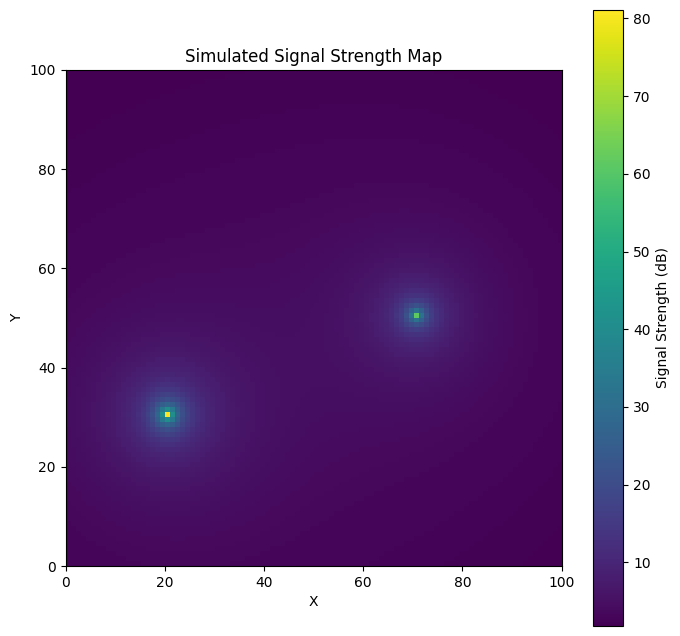

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 仿真区域大小
area_width = 100
area_height = 100

# 基站信息：位置和信号强度
base_stations = [
    {'x': 20, 'y': 30, 'strength': 80},
    {'x': 70, 'y': 50, 'strength': 60},
    # 可以添加更多基站信息
]

# 创建仿真区域的网格
grid_x, grid_y = np.meshgrid(np.arange(0, area_width), np.arange(0, area_height))

# 初始化信号强度数组
signal_strength = np.zeros_like(grid_x, dtype=np.float64)

# 计算每个网格点的信号强度
for station in base_stations:
    distance = np.sqrt((grid_x - station['x'])**2 + (grid_y - station['y'])**2)
    signal_strength += float(station['strength']) / (distance + 1)  # 防止除以零

# 绘制仿真地图
plt.figure(figsize=(8, 8))
plt.imshow(signal_strength, cmap='viridis', origin='lower', extent=[0, area_width, 0, area_height])
plt.colorbar(label='Signal Strength (dB)')
plt.title('Simulated Signal Strength Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [5]:
import shapefile
import geopandas as gpd
from shapely.geometry import Point

# 1. 收集数据
antenna_azimuth = 120  # 基站天线方位角
antenna_height = 30    # 基站天线高度（假设单位为米）
frequency = 2000       # 基站频率（假设单位为MHz）

# 2. 计算信号覆盖强度（这里只是示意，实际使用需要根据传播模型计算）
def calculate_signal_strength(distance):
    return -distance  # 这只是一个简单的示例，实际情况需使用传播模型计算

# 3. 生成地图数据
# 假设有一个GeoDataFrame表示地理数据
geo_data = gpd.read_file('path_to_geo_data.geojson')

coverage_data = []
for index, row in geo_data.iterrows():
    point = row['geometry']
    distance = calculate_distance_between_points(point, base_station_location)
    signal_strength = calculate_signal_strength(distance)
    coverage_data.append({'geometry': point, 'signal_strength': signal_strength})

coverage_gdf = gpd.GeoDataFrame(coverage_data)

# 4. 生成SHp格式地图
shp_filename = 'coverage_map.shp'
coverage_gdf.to_file(shp_filename, driver='ESRI Shapefile')

print("SHp格式地图已生成：", shp_filename)


DriverError: path_to_geo_data.geojson: No such file or directory

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# 示例基站参数列表，每个基站包括经纬度、天线方位角、高度、频率等信息
base_stations = [
    {"lat": 40.7128, "lon": -74.0060, "azimuth": 120, "height": 30, "frequency": 900},
    # 添加更多基站参数
]

# 使用信号传播模型计算信号覆盖范围，这里使用简化的自由空间路径损耗模型
def calculate_coverage_range(lat, lon, azimuth, height, frequency):
    # 假设使用Free Space Path Loss模型来计算信号强度
    distance = np.linspace(0, 10, 100)  # 距离范围，单位：km
    path_loss = 20 * np.log10(distance) + 20 * np.log10(frequency) + 92.45
    coverage_radius = distance[np.where(path_loss < -120)][-1]  # 假设信号强度阈值为-120 dBm
    return coverage_radius

# 创建地理空间DataFrame
geometry = [Point(lon, lat) for station in base_stations]
crs = {'init': 'epsg:4326'}  # WGS 84坐标系
gdf = gpd.GeoDataFrame(base_stations, geometry=geometry, crs=crs)

# 计算每个基站的信号覆盖范围
gdf['coverage_radius'] = gdf.apply(
    lambda row: calculate_coverage_range(row['lat'], row['lon'], row['azimuth'], row['height'], row['frequency']),
    axis=1
)

# 绘制地图
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['coverage_radius']*2000, alpha=0.5)

plt.title('Signal Coverage Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


NameError: name 'lon' is not defined

C:\Users\asunc\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\asunc\AppData\Local\Temp\ipykernel_6048\1549106697.py:16: RuntimeWarning: divide by zero encountered in log10
  path_loss = 20 * np.log10(distance) + 20 * np.log10(frequency) + 92.45
C:\Users\asunc\AppData\Local\Temp\ipykernel_6048\1549106697.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


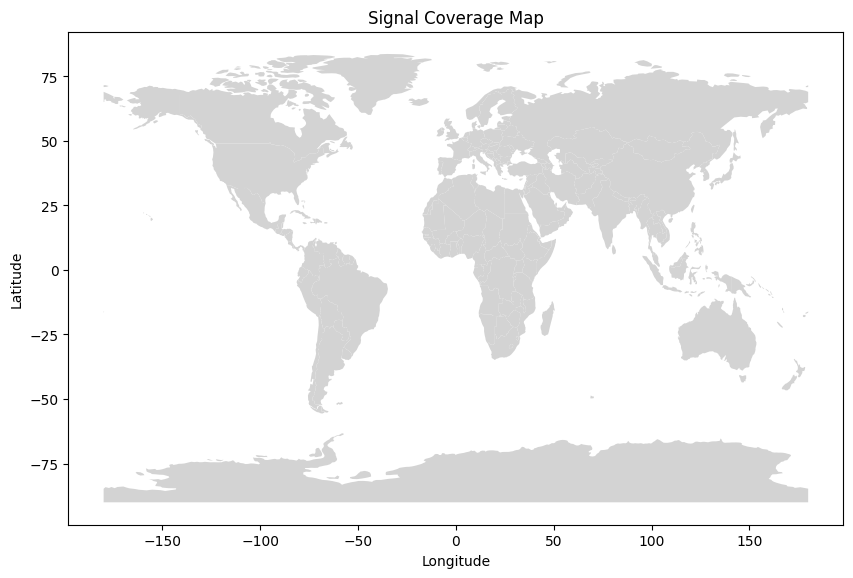

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# 示例基站参数列表，每个基站包括经纬度、天线方位角、高度、频率等信息
base_stations = [
    {"lat": 40.7128, "lon": 112.0060, "azimuth": 120, "height": 30, "frequency": 900},
    # 添加更多基站参数
]

# 使用信号传播模型计算信号覆盖范围，这里使用简化的自由空间路径损耗模型
def calculate_coverage_range(lat, lon, azimuth, height, frequency):
    # 假设使用Free Space Path Loss模型来计算信号强度
    distance = np.linspace(0, 10, 100)  # 距离范围，单位：km
    path_loss = 20 * np.log10(distance) + 20 * np.log10(frequency) + 92.45
    coverage_radius = distance[np.where(path_loss < -120)][-1]  # 假设信号强度阈值为-120 dBm
    return coverage_radius

# 创建地理空间DataFrame
geometry = [Point(station["lon"], station["lat"]) for station in base_stations]
crs = {'init': 'epsg:4326'}  # WGS 84坐标系
gdf = gpd.GeoDataFrame(base_stations, geometry=geometry, crs=crs)

# 计算每个基站的信号覆盖范围
gdf['coverage_radius'] = gdf.apply(
    lambda row: calculate_coverage_range(row['lat'], row['lon'], row['azimuth'], row['height'], row['frequency']),
    axis=1
)

# 绘制地图
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['coverage_radius']*2000, alpha=0.5)

plt.title('Signal Coverage Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [27]:
import geopandas as gpd
from shapely.geometry import Point
from math import log10
import math
import csv

 

# 读取基站数据
def read_station_data(filename):
    # 从CSV文件中读取基站数据
    # 返回一个包含基站信息的列表，每个基站包括经度、纬度、方位角、高度、频率等参数
    # 格式：[(经度, 纬度, 方位角, 高度, 频率), ...]
    station_data = []
    
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # 跳过标题行
        for row in csv_reader:
            distance,longitude, latitude, azimuth, height, frequency = map(float, row)
            station_data.append((distance,longitude, latitude, azimuth, height, frequency))
    
    return station_data

# 计算信号覆盖强度（这里使用简化的自由空间传播模型）
def calculate_signal_strength(distance,frequency, height_tx, height_rx):
    # 计算信号强度
    # 返回信号强度（例如RSRP电平值）
   # 自由空间传播模型的计算公式
    # 注意：以下参数均采用国际单位制，频率为赫兹，距离为米，高度为米
    c = 3 * 10**8  # 光速，单位：米/秒
    lambda_ = c / frequency  # 波长，单位：米
    # 计算阻尼因子（damping factor）
    damping = 20 * math.log10(4 * math.pi * distance / lambda_)
    # 计算自由空间损耗（free space path loss）
    fspl = 20 * math.log10(distance) + 20 * math.log10(frequency) + 20 * math.log10(4 * math.pi / c)
    # 计算接收增益（gain）
    # 这里使用简化的模型，通常还需要考虑天线增益等因素
    gain = 0  # 假设为0
    # 计算信号强度（RSRP电平值）
    rsrp = 10 * math.log10(10**((height_tx + height_rx - fspl + gain - damping) / 10))
    return rsrp


def main():
    # 读取基站数据
    station_data = read_station_data("station_data.csv")
    #print(station_data)
    # 创建地图DataFrame
    map_data = []

    for station in station_data:
        distance,longitude, latitude, azimuth, height, frequency = station
        print(station)
        # 假设接收点在基站下方一定距离处，计算接收点的经纬度
        # 使用Shapely库创建点对象
        # 计算距离
        # 计算信号强度
        map_data.append({
            "geometry": Point(longitude, latitude),
            "rsrp": calculate_signal_strength(distance, frequency, height, height),
        })

    # 创建GeoDataFrame
    gdf = gpd.GeoDataFrame(map_data, geometry='geometry')

    # 保存为Shapefile文件
    gdf.to_file("signal_coverage.shp")

if __name__ == "__main__":
    main()


(1500.0, 120.33, 30.46, 120.0, 50.0, 1800.0)
(1500.0, 121.79, 31.23, 90.0, 40.0, 2100.0)
(1500.0, 123.46, 32.01, 60.0, 30.0, 1800.0)
(1500.0, 125.12, 32.79, 30.0, 20.0, 2100.0)
(1500.0, 126.79, 33.57, 0.0, 10.0, 1800.0)
(1500.0, 128.45, 34.35, 30.0, 20.0, 2100.0)


In [28]:
import geopandas as gpd
from shapely.geometry import Point
import folium

# 1. 准备数据（示例数据）
data = [
    {"name": "Base Station 1", "latitude": 40.0, "longitude": -80.0, "azimuth": 90, "height": 30, "frequency": 2000},
    # ... 其他基站数据 ...
]

# 2. 计算信号覆盖范围并生成地理空间数据（示例）
coverage_areas = []
for station in data:
    # 计算信号覆盖范围并将其转换为Shapely几何对象
    # 这里需要使用适当的信号传播模型进行计算，这里仅作示例
    coverage_geometry = ...  # 使用适当的方法计算覆盖范围
    coverage_areas.append({"geometry": coverage_geometry, "properties": station})

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 3. 生成地图
m = folium.Map(location=[data[0]["latitude"], data[0]["longitude"]], zoom_start=10)

# 4. 添加信号覆盖图层到地图
for idx, row in gdf.iterrows():
    # 在地图上添加覆盖区域
    coverage = folium.GeoJson(row["geometry"].__geo_interface__, style_function=lambda x: {'fillColor': '#ff0000'})
    popup = folium.Popup(row["properties"]["name"])
    popup.add_to(coverage)
    coverage.add_to(m)

# 5. 保存为HTML文件（示例）
m.save('coverage_map.html')

# 导出为Shapefile格式
gdf.to_file('coverage_map.shp')


AttributeError: 'ellipsis' object has no attribute '__geo_interface__'

In [32]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

# 参数设置
frequency = 2000  # 频率（MHz）

# 基站数据示例
base_stations = [
    {"name": "Base Station 1", "latitude": 30.46, "longitude": 112.1345, "azimuth": 90, "height": 30},
    {"name": "Base Station 1", "latitude": 31.23, "longitude": 120.33, "azimuth": 120, "height": 50},
    {"name": "Base Station 1", "latitude": 32.79, "longitude": 121.79, "azimuth": 0, "height": 40},
    # ... 其他基站数据 ...
]

# 计算覆盖范围
def calculate_coverage(base_station):
    # Okumura-Hata 模型参数
    A = 69.55
    B = 26.16
    C = 13.82
    D = 4.97
    h_b = base_station["height"]
    h_m = 1.5  # 移动台高度（一般设为1.5米）
    
    distance_range = np.linspace(1, 10, 100)  # 距离范围（示例）
    signal_strength = A - B * np.log10(frequency) + (C - D * np.log10(frequency)) * np.log10(distance_range)
    
    # 转换经纬度为Shapely点对象
    station_location = Point(base_station["longitude"], base_station["latitude"])
    
    coverage_polygon = []
    for dist, strength in zip(distance_range, signal_strength):
        # 根据方位角计算信号覆盖范围的顶点
        azimuth_rad = np.deg2rad(base_station["azimuth"])
        x = base_station["longitude"] + (dist / 111.32) * np.cos(azimuth_rad)
        y = base_station["latitude"] + (dist / (111.32 * np.cos(np.deg2rad(base_station["latitude"])))) * np.sin(azimuth_rad)
        coverage_polygon.append((x, y))
    
    # 添加信号覆盖范围的多边形
    coverage_polygon.append(coverage_polygon[0])  # 闭合多边形
    coverage_area = Polygon(coverage_polygon)
    
    return {"geometry": coverage_area, "properties": {"name": base_station["name"], "strength": signal_strength.tolist()}}

# 计算所有基站的信号覆盖范围
coverage_areas = [calculate_coverage(station) for station in base_stations]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 生成地图
m = folium.Map(location=[base_stations[0]["latitude"], base_stations[0]["longitude"]], zoom_start=10)

# 添加信号覆盖图层到地图
for idx, row in gdf.iterrows():
    # 在地图上添加覆盖区域
    coverage = folium.GeoJson(row["geometry"].__geo_interface__, style_function=lambda x: {'fillColor': '#ff0000'})
    popup = folium.Popup(f"Name: {row['properties']['name']}<br>Strength: {row['properties']['strength'][0]:.2f} dBm")
    popup.add_to(coverage)
    coverage.add_to(m)

# 保存为HTML文件和Shapefile格式
m.save('coverage_map.html')
gdf.to_file('coverage_map.shp')


In [33]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

# 参数设置
frequency = 2000  # 频率（MHz）
rsrp_levels = [-50, -85, -95, -105, -115, -120]

# 基站数据示例
base_stations = [
   {"name": "Base Station 1", "latitude": 30.46, "longitude": 112.1345, "azimuth": 90, "height": 30},
    {"name": "Base Station 1", "latitude": 31.23, "longitude": 120.33, "azimuth": 120, "height": 50},
    {"name": "Base Station 1", "latitude": 32.79, "longitude": 121.79, "azimuth": 0, "height": 40},
    # ... 其他基站数据 ...
]

# 计算覆盖范围
def calculate_coverage(base_station):
    # Okumura-Hata 模型参数
    A = 69.55
    B = 26.16
    C = 13.82
    D = 4.97
    h_b = base_station["height"]
    h_m = 1.5  # 移动台高度（一般设为1.5米）
    
    distance_range = np.linspace(1, 10, 100)  # 距离范围（示例）
    signal_strength = A - B * np.log10(frequency) + (C - D * np.log10(frequency)) * np.log10(distance_range)
    
    # 转换经纬度为Shapely点对象
    station_location = Point(base_station["longitude"], base_station["latitude"])
    
    coverage_polygon = []
    for dist, strength in zip(distance_range, signal_strength):
        # 根据方位角计算信号覆盖范围的顶点
        azimuth_rad = np.deg2rad(base_station["azimuth"])
        x = base_station["longitude"] + (dist / 111.32) * np.cos(azimuth_rad)
        y = base_station["latitude"] + (dist / (111.32 * np.cos(np.deg2rad(base_station["latitude"])))) * np.sin(azimuth_rad)
        coverage_polygon.append((x, y))
    
    # 添加信号覆盖范围的多边形
    coverage_polygon.append(coverage_polygon[0])  # 闭合多边形
    coverage_area = Polygon(coverage_polygon)
    
    return {"geometry": coverage_area, "properties": {"name": base_station["name"], "strength": signal_strength.tolist()}}

# 计算所有基站的信号覆盖范围
coverage_areas = [calculate_coverage(station) for station in base_stations]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 分段映射颜色
def color_map(value):
    colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF4500', '#8B0000', '#000000']
    for i in range(len(rsrp_levels)):
        if value >= rsrp_levels[i]:
            return colors[i]
    return colors[-1]

# 生成地图
m = folium.Map(location=[base_stations[0]["latitude"], base_stations[0]["longitude"]], zoom_start=10)

# 添加信号覆盖图层到地图
for idx, row in gdf.iterrows():
    # 在地图上添加覆盖区域
    coverage = folium.GeoJson(row["geometry"].__geo_interface__, style_function=lambda x: {'fillColor': color_map(row['properties']['strength'][0]), 'color': 'black', 'fillOpacity': 0.7})
    popup = folium.Popup(f"Name: {row['properties']['name']}<br>Strength: {row['properties']['strength'][0]:.2f} dBm")
    popup.add_to(coverage)
    coverage.add_to(m)

# 保存为HTML文件和Shapefile格式
m.save('coverage_map.html')
gdf.to_file('coverage_map.shp')


In [37]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

# 参数设置
frequency = 2000  # 频率（MHz）
rsrp_levels = [-50, -85, -95, -105, -115, -120]

# 基站数据示例
base_stations = [
   {"name": "Base Station 1", "latitude": 30.46, "longitude": 112.1345, "azimuth": 90, "height": 30},
    {"name": "Base Station 1", "latitude": 31.23, "longitude": 120.33, "azimuth": 120, "height": 50},
    {"name": "Base Station 1", "latitude": 32.79, "longitude": 121.79, "azimuth": 0, "height": 40},
    # ... 其他基站数据 ...
]

# 计算覆盖范围
def calculate_coverage(base_station):
    # Okumura-Hata 模型参数
    A = 69.55
    B = 26.16
    C = 13.82
    D = 4.97
    h_b = base_station["height"]
    h_m = 1.5  # 移动台高度（一般设为1.5米）
    
    distance_range = np.linspace(1, 10, 100)  # 距离范围（示例）
    signal_strength = A - B * np.log10(frequency) + (C - D * np.log10(frequency)) * np.log10(distance_range)
    
    # 转换经纬度为Shapely点对象
    station_location = Point(base_station["longitude"], base_station["latitude"])
    
    coverage_polygon = []
    for dist, strength in zip(distance_range, signal_strength):
        # 根据方位角计算信号覆盖范围的顶点
        azimuth_rad = np.deg2rad(base_station["azimuth"])
        x = base_station["longitude"] + (dist / 111.32) * np.cos(azimuth_rad)
        y = base_station["latitude"] + (dist / (111.32 * np.cos(np.deg2rad(base_station["latitude"])))) * np.sin(azimuth_rad)
        coverage_polygon.append((x, y))
    
    # 添加信号覆盖范围的多边形
    coverage_polygon.append(coverage_polygon[0])  # 闭合多边形
    coverage_area = Polygon(coverage_polygon)
    
    return {"geometry": coverage_area, "properties": {"name": base_station["name"], "strength": signal_strength[0]}}

# 计算所有基站的信号覆盖范围
coverage_areas = [calculate_coverage(station) for station in base_stations]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 添加RSRP电平值字段
gdf["rsrp_levels"] = np.interp(gdf['properties'].apply(lambda x: x['strength']), rsrp_levels, range(len(rsrp_levels)))

# 分段映射颜色
def color_map(value):
    colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF4500', '#8B0000', '#000000']
    return colors[int(value)]

# 生成地图
m = folium.Map(location=[base_stations[0]["latitude"], base_stations[0]["longitude"]], zoom_start=10)

# 添加信号覆盖图层到地图
for idx, row in gdf.iterrows():
    # 在地图上添加覆盖区域
    coverage = folium.GeoJson(row["geometry"].__geo_interface__, style_function=lambda x: {'fillColor': color_map(row['rsrp_levels']), 'color': 'black', 'fillOpacity': 0.7})
    popup = folium.Popup(f"Name: {row['properties']['name']}<br>Strength: {row['properties']['strength']:.2f} dBm")
    popup.add_to(coverage)
    coverage.add_to(m)

# 保存为HTML文件和Shapefile格式
m.save('coverage_map.html')
gdf.to_file('coverage_map.shp')


C:\Users\asunc\AppData\Local\Temp\ipykernel_6048\3828121071.py:75: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('coverage_map.shp')


In [38]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

# 参数设置
frequency = 2000  # 频率（MHz）
rsrp_levels = [-50, -85, -95, -105, -115, -120]

# 基站数据示例
base_stations = [
   {"name": "Base Station 1", "latitude": 30.46, "longitude": 112.1345, "azimuth": 90, "height": 30},
    {"name": "Base Station 1", "latitude": 31.23, "longitude": 120.33, "azimuth": 120, "height": 50},
    {"name": "Base Station 1", "latitude": 32.79, "longitude": 121.79, "azimuth": 0, "height": 40},
    # ... 其他基站数据 ...
]

# 计算覆盖范围
def calculate_coverage(base_station):
    # Okumura-Hata 模型参数
    A = 69.55
    B = 26.16
    C = 13.82
    D = 4.97
    h_b = base_station["height"]
    h_m = 1.5  # 移动台高度（一般设为1.5米）
    
    distance_range = np.linspace(1, 10, 100)  # 距离范围（示例）
    signal_strength = A - B * np.log10(frequency) + (C - D * np.log10(frequency)) * np.log10(distance_range)
    
    # 转换经纬度为Shapely点对象
    station_location = Point(base_station["longitude"], base_station["latitude"])
    
    coverage_polygon = []
    for dist, strength in zip(distance_range, signal_strength):
        # 根据方位角计算信号覆盖范围的顶点
        azimuth_rad = np.deg2rad(base_station["azimuth"])
        x = base_station["longitude"] + (dist / 111.32) * np.cos(azimuth_rad)
        y = base_station["latitude"] + (dist / (111.32 * np.cos(np.deg2rad(base_station["latitude"])))) * np.sin(azimuth_rad)
        coverage_polygon.append((x, y))
    
    # 添加信号覆盖范围的多边形
    coverage_polygon.append(coverage_polygon[0])  # 闭合多边形
    coverage_area = Polygon(coverage_polygon)
    
    return {"geometry": coverage_area, "properties": {"name": base_station["name"], "strength": signal_strength[0]}}

# 计算所有基站的信号覆盖范围
coverage_areas = [calculate_coverage(station) for station in base_stations]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 添加RSRP电平值字段
gdf["rsrp_levels"] = np.interp(gdf['properties'].apply(lambda x: x['strength']), rsrp_levels, range(len(rsrp_levels)))

# 分段映射颜色
def color_map(value):
    colors = ['#00FF00', '#FFFF00', '#FFA500', '#FF4500', '#8B0000', '#000000']
    return colors[int(value)]

# 生成地图
m = folium.Map(location=[base_stations[0]["latitude"], base_stations[0]["longitude"]], zoom_start=10)

# 添加信号覆盖图层到地图
for idx, row in gdf.iterrows():
    # 在地图上添加覆盖区域
    coverage = folium.GeoJson(row["geometry"].__geo_interface__, style_function=lambda x: {'fillColor': color_map(row['rsrp_levels']), 'color': 'black', 'fillOpacity': 0.7})
    popup = folium.Popup(f"Name: {row['properties']['name']}<br>Strength: {row['properties']['strength']:.2f} dBm")
    popup.add_to(coverage)
    coverage.add_to(m)

# 保存为HTML文件和Shapefile格式
m.save('coverage_map.html')
gdf.to_file('coverage_map.shp')


C:\Users\asunc\AppData\Local\Temp\ipykernel_6048\3828121071.py:75: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('coverage_map.shp')


In [40]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from scipy.interpolate import griddata

# 参数设置
frequency = 2000  # 频率（MHz）
rsrp_levels = [-50, -85, -95, -105, -115, -120]

# 基站数据示例
base_stations = [
    {"name": "Base Station 1", "latitude": 40.0, "longitude": -80.0, "azimuth": 90, "height": 30, "antenna_gain": 8, "half_power_angle": 30},
    # ... 其他基站数据 ...
]

# 计算覆盖范围
def calculate_coverage(base_station):
    # Okumura-Hata 模型参数
    A = 69.55
    B = 26.16
    C = 13.82
    D = 4.97
    h_b = base_station["height"]
    h_m = 1.5  # 移动台高度（一般设为1.5米）
    
    distance_range = np.linspace(1, 10, 100)  # 距离范围（示例）
    signal_strength = A - B * np.log10(frequency) + (C - D * np.log10(frequency)) * np.log10(distance_range)
    
    # 转换经纬度为Shapely点对象
    station_location = Point(base_station["longitude"], base_station["latitude"])
    
    coverage_polygon = []
    for dist, strength in zip(distance_range, signal_strength):
        # 根据方位角计算信号覆盖范围的顶点
        azimuth_rad = np.deg2rad(base_station["azimuth"])
        x = base_station["longitude"] + (dist / 111.32) * np.cos(azimuth_rad)
        y = base_station["latitude"] + (dist / (111.32 * np.cos(np.deg2rad(base_station["latitude"])))) * np.sin(azimuth_rad)
        coverage_polygon.append((x, y))
    
    return {"geometry": Polygon(coverage_polygon), "properties": {"name": base_station["name"], "strength": strength}}

# 计算所有基站的信号覆盖范围
coverage_areas = [calculate_coverage(station) for station in base_stations]

# 创建GeoDataFrame
gdf = gpd.GeoDataFrame(coverage_areas)

# 添加RSRP电平值字段
gdf["rsrp_levels"] = np.interp(gdf['properties'].apply(lambda x: x['strength']), rsrp_levels, range(len(rsrp_levels)))

# 生成地图
m = folium.Map(location=[base_stations[0]["latitude"], base_stations[0]["longitude"]], zoom_start=10)

# 插值网格点
grid_x, grid_y = np.meshgrid(np.linspace(min(gdf['geometry'].bounds['minx']), max(gdf['geometry'].bounds['maxx']), 100),
                             np.linspace(min(gdf['geometry'].bounds['miny']), max(gdf['geometry'].bounds['maxy']), 100))

# 插值计算
grid_strength = griddata((gdf['geometry'].x, gdf['geometry'].y), gdf['rsrp_levels'], (grid_x, grid_y), method='cubic')

# 添加信号覆盖图层到地图
folium.raster_layers.ImageOverlay(
    image=grid_strength,
    bounds=[[grid_x.min(), grid_y.min()], [grid_x.max(), grid_y.max()]],
    opacity=0.7,
).add_to(m)

# 保存为HTML文件
m.save('coverage_map.html')


ModuleNotFoundError: No module named 'scipy.optimize._trlib._trlib'

In [3]:
import torch
import zipfile
import torchaudio
from glob import glob

device = torch.device('cpu')  # gpu also works, but our models are fast enough for CPU

model, decoder, utils = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                       model='silero_stt',
                                       language='en', # also available 'de', 'es'
                                       device=device)
(read_batch, split_into_batches,
 read_audio, prepare_model_input) = utils  # see function signature for details

# download a single file, any format compatible with TorchAudio (soundfile backend)
#torch.hub.download_url_to_file('https://opus-codec.org/static/examples/samples/speech_orig.wav',
                               #dst ='speech_orig.wav', progress=True)

 

test_files = glob('wav/20220921_110131.wav')
batches = split_into_batches(test_files, batch_size=10)
input = prepare_model_input(read_batch(batches[0]),
                            device=device)

output = model(input)
for example in output:
    print(decoder(example.cpu()))

Using cache found in C:\Users\Asun/.cache\torch\hub\snakers4_silero-models_master


i what's you the times the team which a man i can of with the me toldyou let me going to play or kind of thatic was sha i last it


In [2]:
import speech_recognition as sr
from pydub import AudioSegment
 
# 定义函数将视频转换为音频并保存到本地
def video_to_audio(video_path):
    # 导入视频处理模块（这里使用ffmpeg）
    from moviepy.editor import VideoFileClip
    
    # 提取视频中的音频部分
    audio = VideoFileClip(video_path).audio
    
    # 设置输出音频格式及路径
    output_file = "output.wav"
    
    # 保存音频到本地
    audio.write_audiofile(output_file)
    
    return output_file
 
# 加载音频文件
audio_file = video_to_audio("2024-01-08 14-02-35.mkv")
 
# 创建Recognizer对象
r = sr.Recognizer()
 
# 打开音频文件
with sr.AudioFile(audio_file) as source:
    # 从音频文件中获取音频流
    audio = r.record(source) 
try:
    # 使用Google Web Speech API进行语音识别
    text = r.recognize_google(audio, language='zh-CN')
    print('转换结果：', text)
except Exception as e:
    print('发生错误：', str(e))

MoviePy - Writing audio in output.wav


MoviePy - Done.
发生错误： recognition request failed: Bad Request
